# Prepare environment

In [ ]:
!pip install datasets langchain[llms]

In [ ]:
import asyncio
import datasets
import numpy as np
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.output_parsers import StructuredOutputParser, OutputFixingParser, ResponseSchema
from langchain.callbacks import get_openai_callback
from datetime import datetime
import time
import pickle
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configure general variables
seed = 42
openai_org = "..."
openai_key = "..."

# Prepare datasets

In [ ]:
# Load the real papers from the original test dataset
test = datasets.load_dataset("tum-nlp/IDMGSP", "classifier_input", split="test")
test_real = test.filter(lambda x: x["src"] == "real")

test_real

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'year', 'title', 'abstract', 'introduction', 'conclusion', 'categories', 'src', 'label'],
    num_rows: 4000
})

# Define prompting functions

In [ ]:
def count_words(text):
    return len(text.split())


async def paraphrase_paper_parallel(model, abstract, introduction, conclusion):
    # Define the prompt template for the system message with task instructions
    system_message_template = SystemMessagePromptTemplate(prompt=PromptTemplate(
        template="Your task is to paraphrase the '{section}' section from a scientific paper. The paraphrased section should present the same ideas as the original and should have a similar length.",
        # template="Your task is to paraphrase the '{section}' section from a scientific paper. The paraphrased section should present the same ideas as the original and should have a length of {word_count} words.",
        input_variables=["section", "word_count"]
    ))

    # Define the prompt template for passing the scientific paper
    human_message_template = HumanMessagePromptTemplate(prompt=PromptTemplate(
        template="{text}",
        input_variables=["text"]
    ))

    # Combine the prompt templates into a chat prompt template
    prompt_template = ChatPromptTemplate.from_messages([system_message_template, human_message_template])

    # Define a function to asynchronously paraphrase one section
    async def paraphrase_section(section, text):
        messages = prompt_template.format_prompt(section=section, word_count=count_words(text), text=text).to_messages()
        return await model.apredict_messages(messages), messages

    # Define a function to paraphrase multiple sections in parallel
    async def paraphrase_sections():
        tasks = [paraphrase_section(*s) for s in [
            ("abstract", abstract),
            ("introduction", introduction),
            ("conclusion", conclusion)
        ]]
        return await asyncio.gather(*tasks)

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        results = await paraphrase_sections()

        abstract, introduction, conclusion = [r[0].content for r in results]
        messages = [r[1] for r in results]
        output = [r[0] for r in results]

        return abstract, introduction, conclusion, messages, output, cb

# Run experiments

In [ ]:
# Initialize a list to log experiment results
results_log = []
error_log = []

In [ ]:
# Set up functionality to store experimental results for later evaluation
def log_result(index, abstr_in, intro_in, concl_in, abstr_out, intro_out, concl_out, msg_in, msg_out, model_name, temperature, total_tokens, prompt_tokens, completion_tokens, cost, duration):
    log = {
        "index": index,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "config": {
            "model": model_name,
            "temperature": temperature
        },
        "original": {
            "abstract": abstr_in,
            "introduction": intro_in,
            "conclusion": concl_in
        },
        "paraphrased": {
            "abstract": abstr_out,
            "introduction": intro_out,
            "conclusion": concl_out
        },
        "input_messages": msg_in,
        "output_messages": msg_out,
        "consumption": {
            "tokens_used": total_tokens,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "cost": cost
        },
        "duration": duration
    }

    results_log.append(log)
    return log


# Set up functionality to log errors
def log_error(index, error):
    error_log.append({"index": index, "error": error})


# Define function run an experiment
async def run_experiment(n_sample, start=0, temperature=1.0, verbose=True):
    # Set up the model
    model = ChatOpenAI(model="gpt-3.5-turbo-0613", temperature=temperature, openai_api_key=openai_key, openai_organization=openai_org)

    # Run the experiment
    for i in range(start, n_sample):
        try:
            start_time = time.time()

            # Run the prompt
            abstract, introduction, conclusion, messages, output, consumption = await paraphrase_paper_parallel(model, test_real["abstract"][i], test_real["introduction"][i], test_real["conclusion"][i])

            duration = time.time() - start_time

            # Store and print the results
            log_result(i, test_real["abstract"][i], test_real["introduction"][i], test_real["conclusion"][i], abstract, introduction, conclusion, messages, output, model.model_name, model.temperature, consumption.total_tokens, consumption.prompt_tokens, consumption.completion_tokens, consumption.total_cost, duration)
            if verbose:
                print(f"Example {i+1} of {n_sample}: {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
        except Exception as e:
            log_error(i, e)
            if verbose:
                print(f"Example {i+1} of {n_sample}: Error {e}")

In [ ]:
await run_experiment(n_sample=4000, start=0)

In [ ]:
# Store the results
filename = "2023_07_24 - Paraphrased 0-4000.pickle"
pickle_out = open(filename, "wb")
pickle.dump(results_log, pickle_out)
pickle_out.close()

# Download the results
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the results
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Unpickle the results
pickle_in = open(filename, "rb")
results_log = pickle.load(pickle_in)

In [ ]:
len(results_log)

4000

# Evaluate results

In [ ]:
# Convert the logged results into a pandas DataFrame
df = pd.json_normalize(results_log, sep='_')

In [ ]:
df[["consumption_tokens_used", "consumption_prompt_tokens", "consumption_completion_tokens", "consumption_cost", "duration"]].describe()

,consumption_tokens_used,consumption_prompt_tokens,consumption_completion_tokens,consumption_cost,duration
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2053.416250,1263.158500,790.257750,0.003475,16.015293
std,580.555694,382.749024,228.032955,0.000976,21.946510
min,573.000000,389.000000,178.000000,0.000949,3.209501
25%,1625.750000,978.750000,626.000000,0.002757,10.164263
50%,2029.000000,1253.500000,765.500000,0.003424,13.309575
75%,2453.000000,1519.000000,937.000000,0.004148,17.134296
max,4077.000000,2640.000000,1729.000000,0.006971,346.223013


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
from tqdm.auto import tqdm

tokenizer = AutoTokenizer.from_pretrained('facebook/galactica-1.3b')
tqdm.pandas()

In [ ]:
# def count_words(text):
#     return text.str.split().str.len()

def count_tokens(text):
    return len(tokenizer.encode(text))

# Calculate word counts for both, original and paraphrased versions.
df_word_counts = df[['original_abstract', 'paraphrased_abstract', 'original_introduction', 'paraphrased_introduction', 'original_conclusion', 'paraphrased_conclusion']].progress_applymap(count_tokens)

  0%|          | 0/24000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

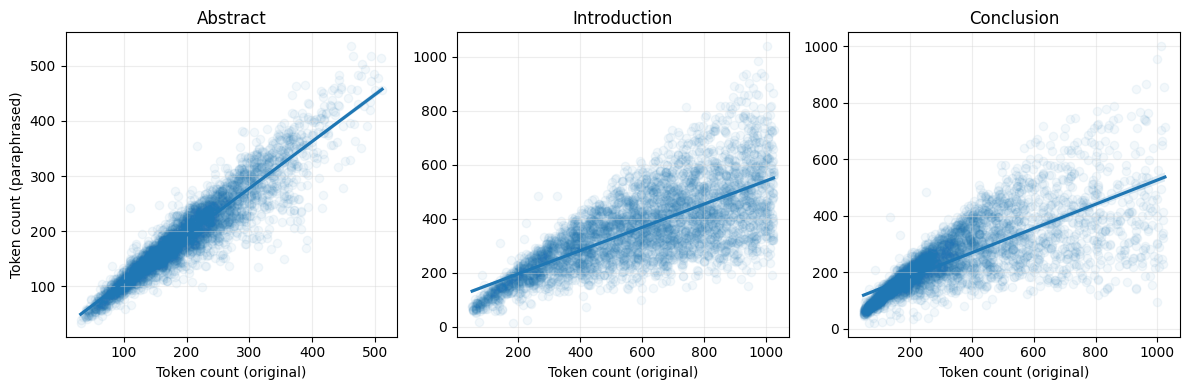

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Abstract
sns.regplot(x='original_abstract', y='paraphrased_abstract', data=df_word_counts, ax=axs[0], scatter_kws={'alpha':0.05})
axs[0].set_title('Abstract')
axs[0].set_xlabel('Token count (original)')
axs[0].set_ylabel('Token count (paraphrased)')
axs[0].grid(True, color='#d3d3d3', alpha=0.4)

# Introduction
sns.regplot(x='original_introduction', y='paraphrased_introduction', data=df_word_counts, ax=axs[1], scatter_kws={'alpha':0.05})
axs[1].set_title('Introduction')
axs[1].set_xlabel('Token count (original)')
axs[1].set_ylabel('')
axs[1].grid(True, color='#d3d3d3', alpha=0.4)

# Conclusion
sns.regplot(x='original_conclusion', y='paraphrased_conclusion', data=df_word_counts, ax=axs[2], scatter_kws={'alpha':0.05})
axs[2].set_title('Conclusion')
axs[2].set_xlabel('Token count (original)')
axs[2].set_ylabel('')
axs[2].grid(True, color='#d3d3d3', alpha=0.4)

plt.tight_layout()

# Store and download the plot
filename = "paraphrased_length.pdf"
plt.savefig(filename, format="pdf", bbox_inches="tight")
files.download(filename)

plt.show()

In [ ]:
# Download a dataset with the original and paraphrased papers as a CSV
filename = "20230724_paraphrased_test_4000.csv"
df[['original_abstract', 'original_introduction', 'original_conclusion', 'paraphrased_abstract', 'paraphrased_introduction', 'paraphrased_conclusion']].to_csv(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Investigate the dataset for faulty rows

In [ ]:
# Measure the length of the paraphrased sections
df["length_abstract"] = df["paraphrased_abstract"].apply(lambda x: len(x))
df["length_introduction"] = df["paraphrased_introduction"].apply(lambda x: len(x))
df["length_conclusion"] = df["paraphrased_conclusion"].apply(lambda x: len(x))

In [ ]:
# Sense-check the distribution of section lengths
df[["length_abstract", "length_introduction", "length_conclusion"]].describe()

,length_abstract,length_introduction,length_conclusion
count,4000.000000,4000.000000,4000.000000
mean,1005.939500,1913.741500,1253.380500
std,349.575827,806.104691,615.794122
min,195.000000,71.000000,89.000000
25%,759.000000,1328.000000,813.000000
50%,982.000000,1852.000000,1137.000000
75%,1224.000000,2440.250000,1572.250000
max,2396.000000,5367.000000,4688.000000


In [ ]:
# Examine the shortest abstracts
df[["length_abstract", "original_abstract", "paraphrased_abstract"]].sort_values(by="length_abstract", ascending=True).head(20)

,length_abstract,original_abstract,paraphrased_abstract
3845,195,We review recent work on the effective field t...,"In this review, we examine recent advancements..."
790,199,We present herein our experience with the cali...,"In this article, we discuss our experience wit..."
272,200,We present several supercongruences that may b...,"In this paper, we introduce a collection of su..."
1092,210,Our Multi-Column Deep Neural Networks achieve ...,Our Multi-Column Deep Neural Networks have ach...
2235,213,We define bilateral series related to Ramanuja...,"In this study, we introduce bilateral series t..."
1099,234,We study how the rapidity evolution of gluon t...,"In our research, we examine the transformation..."
3309,235,"Papers on ice properties, reconstruction and f...",In the 33rd International Cosmic Ray Conferenc...
866,239,In this paper we selected a sample of massive ...,This study focused on the examination of star ...
1245,241,SModelS is a tool for the automatic interpreta...,"SModelS v1.0, an automated tool for interpreti..."
3947,243,In this paper we give general recommendations ...,This paper provides general guidelines for eff...


In [ ]:
# Examine the shortest introductions
df[["length_introduction", "original_introduction", "paraphrased_introduction"]].sort_values(by="length_introduction", ascending=True).head(20)

,length_introduction,original_introduction,paraphrased_introduction
2472,71,1.1. Related Work . . . . . . . . . . . . . . ...,1.1. Background Research ... (Write your parap...
3941,81,"Please cite this article as: Cuevas, E., War...",Please include the introduction section of the...
825,97,1.1 Motivation of the Thesis . . . . . . . . ....,1.1 Rationale for the Research\n1.2 Overview o...
352,157,"size of the growing domains [19, 20, 21, 22, 2...","The dimensions of the expanding areas [19, 20,..."
3530,173,"2 Worldine formalism, Wilson loops and hologra...","2 Worldline formalism, Wilson loops and hologr..."
2788,185,"O), KCaX2 (X = C, N and O), RbSrZ. (Z = C, Si ...","Several compounds, such as LiCaX2, KCaX2 (wher..."
35,200,We can set the optimization so as to update pa...,The optimization can be adjusted to update par...
995,201,"Beyond the forces of the S U3,c × S U2,L × U1,...","Other than the forces described by the SM, the..."
3872,203,1.1 Introduction . . . . . . . . . . . . . . ....,1.1 Background information . . . . . . . . . ....
2815,214,2 Analytically matching dynamics 4 2.1 Matchin...,2 Analytically reconciling dynamics 4\n2.1 Rec...


In [ ]:
# Examine the shortest conclusions
df[["length_conclusion", "original_conclusion", "paraphrased_conclusion"]].sort_values(by="length_conclusion", ascending=True).head(20)

,length_conclusion,original_conclusion,paraphrased_conclusion
1527,89,A Appendix 23 A.1 Proof of Proposition 2 . . ....,The evidence presented in Appendix 23 confirms...
1163,94,A.1. n “ 2: the deformed C2 . . . . . . . . . ...,"In summary, the C2 was found to be deformed in..."
108,136,A Proof of Theorem III.1. . . . . . . . . . . ...,The conclusion of the scientific paper provide...
2472,148,B.1. Algorithms . . . . . . . . . . . . . . . ...,"In summary, our study focused on algorithms, s..."
2756,157,"• If ν ̸= 0, α = β = γ = 0 and κ = D2, then th...",An intriguing finding of this study is that th...
3486,166,"νmod f (t) n →θ (t) n (θ(t) n ), to a single G...","In conclusion, the multi-component function νf..."
931,204,"This means that the three heat kernels, that i...","In summary, it has been found that the heat ke..."
282,212,s = 6.964−10.538 GeV are used to determine a v...,The measurement of exclusive and inclusive cha...
1474,219,The minimal polynomial for α1 is p1(x) = x8 − ...,"In accordance with [9], the minimal polynomial..."
754,224,A On the homological perturbation lemma 20 A.1...,"In conclusion, the homological perturbation le..."


In [ ]:
df[df["paraphrased_abstract"].str.contains("paraphras")][["paraphrased_abstract"]]

,paraphrased_abstract
1225,Automated systems often struggle to understand...


In [ ]:
df[df["paraphrased_introduction"].str.contains("paraphras")][["paraphrased_introduction"]]

,paraphrased_introduction
627,The emergence of blockchain technology has gar...
1241,Automated question generation systems have bec...
1735,Codes that can correct insertions and deletion...
1783,The power supply industry is experiencing a si...
1834,The rise of social media platforms like Twitte...
1895,"Constant changes in technology, migration, and..."
2472,1.1. Background Research ... (Write your parap...
2648,The following paraphrase reflects the same ide...
3272,This paper introduces a new lattice invariant ...
3296,Tool support is crucial for the success of for...


In [ ]:
df[df["paraphrased_conclusion"].str.contains("paraphras")][["paraphrased_conclusion"]]

,paraphrased_conclusion
433,"In this study, we have examined two Heisenberg..."
575,"Based on our numerical integrations, the Bosum..."
1225,"In summary, this paper introduced CoQAR, a mod..."
1648,"In conclusion, this study investigated the rel..."


# Assemble the final co-created dataset

In [ ]:
# Convert the original dataset to a Pandas DataFrame for easy manipulation
df_cc = test_real.to_pandas()
df_cc

# Append the paraphrased sections to the original dataframe for easy replacement in the following
df_cc[['paraphrased_abstract', 'paraphrased_introduction', 'paraphrased_conclusion']] = df[['paraphrased_abstract', 'paraphrased_introduction', 'paraphrased_conclusion']]
df_cc["paraphrased_sections"] = ""

# Generate a random permutation of the dataset rows
np.random.seed(seed)
random_order = np.random.permutation(df_cc.index)

# For 1000 random papers, only paraphrase the introduction and keep the abstract and conclusion original/real
paraphrase_i = random_order[:1000]
df_cc.loc[paraphrase_i, "introduction"] = df_cc.loc[paraphrase_i, "paraphrased_introduction"]
df_cc.loc[paraphrase_i, "paraphrased_sections"] = "introduction"

# For 1000 random papers, only paraphrase the conclusion and keep the abstract and introduction original/real
paraphrase_c = random_order[1000:2000]
df_cc.loc[paraphrase_c, "conclusion"] = df_cc.loc[paraphrase_c, "paraphrased_conclusion"]
df_cc.loc[paraphrase_c, "paraphrased_sections"] = "conclusion"

# For 1000 random papers, paraphrase the introduction and conclusion and keep the abstract original/real
paraphrase_ic = random_order[2000:3000]
df_cc.loc[paraphrase_ic, "introduction"] = df_cc.loc[paraphrase_ic, "paraphrased_introduction"]
df_cc.loc[paraphrase_ic, "conclusion"] = df_cc.loc[paraphrase_ic, "paraphrased_conclusion"]
df_cc.loc[paraphrase_ic, "paraphrased_sections"] = "introduction, conclusion"

# For 1000 random papers, paraphrase the abstract, introduction, and conclusion
paraphrase_aic = random_order[3000:4000]
df_cc.loc[paraphrase_aic, "abstract"] = df_cc.loc[paraphrase_aic, "paraphrased_abstract"]
df_cc.loc[paraphrase_aic, "introduction"] = df_cc.loc[paraphrase_aic, "paraphrased_introduction"]
df_cc.loc[paraphrase_aic, "conclusion"] = df_cc.loc[paraphrase_aic, "paraphrased_conclusion"]
df_cc.loc[paraphrase_aic, "paraphrased_sections"] = "abstract, introduction, conclusion"

# Remove the paraphrased columns from the DataFrame again as they have now meen copied to the original columns for the selected rows
df_cc = df_cc.drop(columns=["paraphrased_abstract", "paraphrased_introduction", "paraphrased_conclusion"])

# Mark all papers as fake papers and set their source to ChatGPT (paraphrased)
df_cc["label"] = 1
df_cc["src"] = "chatgpt-paraphrased"

# Reorder the columns
df_cc = df_cc[['id', 'year', 'title', 'abstract', 'introduction', 'conclusion', 'categories', 'src', 'paraphrased_sections', 'label']]

df_cc

,id,year,title,abstract,introduction,conclusion,categories,src,paraphrased_sections,label
0,1705.05462,2017.0,Correlations of $\epsilon^{\prime}_K/\epsilon_...,Recent calculations have pointed to a 2.8 $\si...,CP violating flavor-changing neutral current d...,We have presented the correlations between ϵ′ ...,hep-ph hep-ex,chatgpt-paraphrased,introduction,1
1,2203.14178,2022.0,Energy Efficient VM Placement in a Heterogeneo...,"In recent times, there has been significant pr...",Challenges related to latency and energy effic...,"In this study, we investigated the problem of ...",cs.NI eess.SP,chatgpt-paraphrased,"abstract, introduction, conclusion",1
2,1906.04593,2019.0,Malware Detection with LSTM using Opcode Language,"Nowadays, with the booming development of Inte...","The term ""malware"" refers to malicious softwar...","In this study, we introduce a new and effectiv...",cs.CR cs.SE,chatgpt-paraphrased,"introduction, conclusion",1
3,1209.614,2012.0,DAARIA: Driver Assistance by Augmented Reality...,Taking into account the drivers' state is a ma...,The introduction of this scientific paper high...,"In the context of car driving, there are numer...",cs.HC cs.RO,chatgpt-paraphrased,"introduction, conclusion",1
4,810.5438,2008.0,Self-averaging and criticality: A comparative ...,"In this study, we employ the Wang-Landau (WL) ...",The study of phase transitions in systems with...,"In this study, we examined the impact of quenc...",cond-mat.stat-mech cond-mat.dis-nn,chatgpt-paraphrased,"abstract, introduction, conclusion",1
...,...,...,...,...,...,...,...,...,...,...
3995,2008.06094,2020.0,Novelty Detection Through Model-Based Characte...,"In this paper, we propose a model-based charac...",Characterization of novel data for machine lea...,"To sum up, we have proposed a framework to ass...",cs.CV,chatgpt-paraphrased,conclusion,1
3996,1010.2872,2010.0,Proton Timelike Form Factors Near Threshold vi...,In the reaction of the antiproton-deuteron ele...,Extensive measurements are focused on determin...,"In this study, we have investigated the reacti...",nucl-th hep-ph,chatgpt-paraphrased,"introduction, conclusion",1
3997,1512.04363,2015.0,The dynamics of Wolf numbers based on nonlinea...,We investigate the dynamics of solar activity ...,The study of solar activity dates back to Gali...,"To investigate the solar activity, we use a ve...",astro-ph.SR,chatgpt-paraphrased,introduction,1
3998,1804.02677,2018.0,Early Discovery of Chronic Non-attenders by Us...,Near Field Communication (NFC) standards cover...,Regular school attendance plays a crucial role...,"In conclusion, chronic absenteeism and truancy...",cs.HC cs.NI,chatgpt-paraphrased,"introduction, conclusion",1


In [ ]:
# Download the final co-created dataset as a CSV
filename = "20230725_test_co-created_4000.csv"
df_cc.to_csv(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>